# Store Item Demand - Time Series Analysis w/ Deep Learning

### 1. Imports and settings

**1.1 Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN,\
    SimpleRNNCell, TimeDistributed, MaxPooling1D, Flatten, Conv1D
# from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from time import time
from winsound import Beep
import os
os.chdir('C:/Users/Nicolas/Documents/Scraping/storeitemdemand')

**1.2 Plot settings**

In [2]:
viridis = plt.cm.get_cmap('viridis', 10)

In [3]:
def set_theme():
    return \
        ax.set_facecolor(viridis(4)),\
        ax.minorticks_on(),\
        plt.grid(True, alpha=0.2, color='white', linewidth=2),\
        plt.grid(b=True, which='minor', color='white', alpha=0.1)

**1.3 Timer settings**

In [4]:
def stopwatch():
    if time()-start < 120:
        print(str(int(time()-start)), 'seconds')
    else:
        print(str(int((time()-start)/60)), 'minutes')
    Beep(1000, 5_00)

### 2. Importing and inspecting the data

**2.1 Importing the data**

In [5]:
df = pd.read_csv('train.csv')

**2.2 Inspecting the data**

2.2.1 Head 

In [6]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


2.2.2 Shape

In [7]:
df.shape, df.size

((913000, 4), 3652000)

In [8]:
print(f'We have {df.shape[0]:,} rows and {df.shape[1]} columns, for a total of {df.size:,} data '\
      'points.')

We have 913,000 rows and 4 columns, for a total of 3,652,000 data points.


2.2.4 Getting a list of dates

In [9]:
dates = pd.date_range('1/1/2013', periods=365*5+1, freq='d')

2.2.5 Reshaping the **training** data 

In [10]:
df = df.set_index(['date', 'store', 'item']).unstack(['store', 'item'])

In [11]:
columns = ['s{}_i{}'.format(i, x) for i in range(1, 11) for x in range(1, 51)]

In [12]:
df.columns=columns
df.head().iloc[:, :18]

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,s1_i11,s1_i12,s1_i13,s1_i14,s1_i15,s1_i16,s1_i17,s1_i18
date,,,,,,,,,,,,,,,,,,
2013-01-01,13,12,19,10,11,20,7,16,11,14,33,41,43,30,26,27,21,39
2013-01-02,11,16,8,12,9,6,4,10,9,14,43,33,27,28,22,18,23,25
2013-01-03,14,16,10,8,12,11,8,12,20,16,23,46,38,37,26,20,13,34
2013-01-04,13,20,15,15,8,7,7,21,22,17,18,50,35,44,23,24,34,39
2013-01-05,10,16,22,19,13,12,8,15,22,12,34,44,47,36,22,32,25,45


In [13]:
print(f'The new shape of the data is {df.shape[0]:,} columns by {df.shape[1]} rows.')

The new shape of the data is 1,826 columns by 500 rows.


2.2.6 Separating the time series by store

In [14]:
# for i in range(1, 51):
#     globals()['store_%i'%i] = df.loc[df['store'] == i]

**2.3 Visualizing the time series**

2.3.1 The time series as an array

In [15]:
timeseries = df.mean(axis=1).values.astype(np.int32) # or just one??
timeseries.shape

(1826,)

In [16]:
print('Data type of the time series: {}.'.format(timeseries.dtype))

Data type of the time series: int32.


In [17]:
print(f'The new shape of the data is {timeseries.shape[0]:,} rows.')

The new shape of the data is 1,826 rows.


In [18]:
print(f'The minimum values in the entire dataframe is {timeseries.min():,}'\
          f' and the maximum value is {timeseries.max():,}.')

The minimum values in the entire dataframe is 23 and the maximum value is 89.


2.3.2 Time series time plot

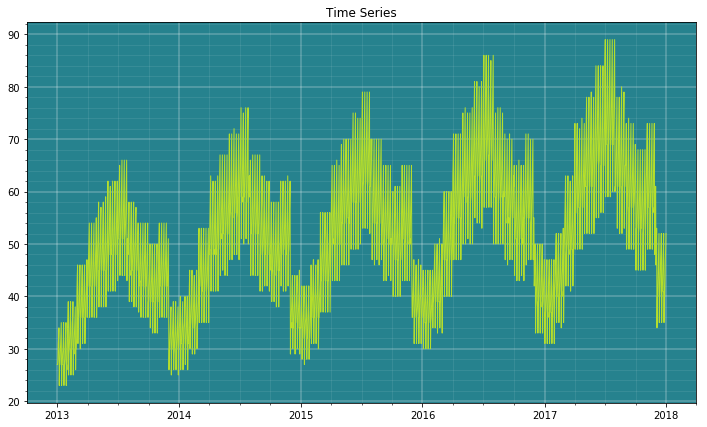

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates, timeseries, lw=1, color=viridis(8))
set_theme()
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title('Time Series')
plt.show()

2.3.3 Time plot, January and February 2013

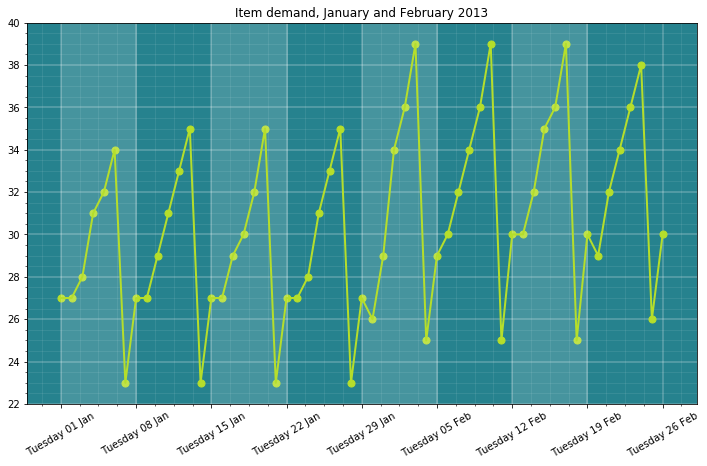

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates.strftime('%A %d %b')[:57], timeseries[:57], 
        lw=2, color=viridis(8))
ax.scatter(dates.strftime('%A %d %b')[:57], timeseries[:57], 
           s=50, color=viridis(8), marker='o')
[ax.axvspan(xmin=dates.strftime('%A %d %b')[:57:7][i], 
            xmax=dates.strftime('%A %d %b')[:57:7][i+1], alpha=0.15, 
            color='white') for i in range(0, 8, 2)]
set_theme()
ax.set_axisbelow(True)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xticks(dates.strftime('%A %d %b')[:57:7], rotation=30)
plt.title('Item demand, January and February 2013')
plt.show()

2.3.4 Time plot of 2013

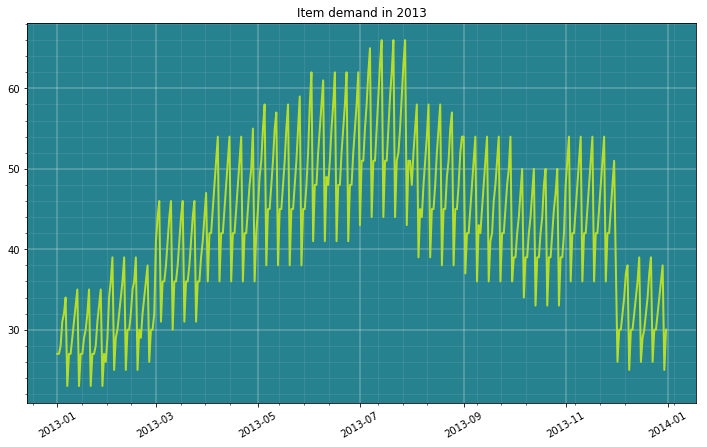

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(pd.date_range('2013-01-01', '2013-12-31', freq='D'), timeseries[:365], 
        lw=2, color=viridis(8))
set_theme()
ax.set_axisbelow(True)
plt.xticks(rotation=30)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                      dtype=int)])
plt.title('Item demand in 2013')
plt.show()

2.3.5 Time plot of 2013 (month over month)

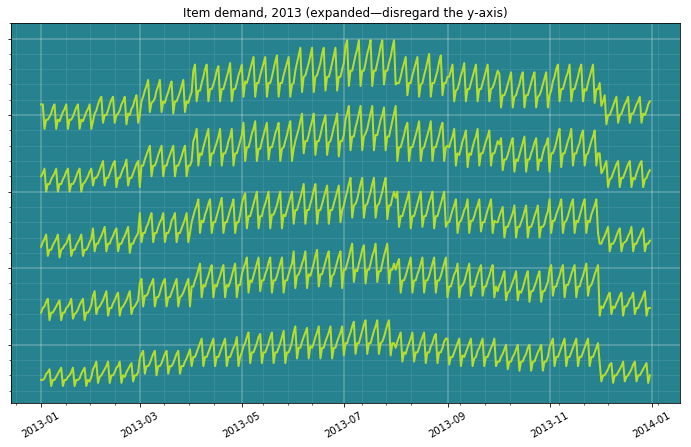

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))
for i in range(5):
    ax.plot(pd.date_range('2013-01-01', '2013-12-31', freq='D'), timeseries[365*i:365*(1+i)]+40*i, # multiply thousands?
        lw=2, color=viridis(8))
set_theme()
ax.set_axisbelow(True)
plt.xticks(rotation=30)
ax.set_yticklabels([])
plt.title('Item demand, 2013 (expanded—disregard the y-axis)')
plt.show()

2.3.5 Effect of week day

In [23]:
day_of_week = pd.date_range('2013-01-01', '2017-12-31', freq='D').to_series() # TODO HERE

In [24]:
df_week_day = pd.concat([df.iloc[:, 0], day_of_week.dt.dayofweek], axis=1, sort=False)

In [25]:
df_week_day.columns = [df_week_day.columns[0], 'Weekday'] 

In [26]:
weekday_effect = df_week_day.groupby('Weekday').mean()
weekday_effect.index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                       'Friday', 'Saturday', 'Sunday']
weekday_effect.columns = ['Mean']
weekday_effect

,Mean
Monday,15.584615
Tuesday,18.168582
Wednesday,18.793103
Thursday,19.452107
Friday,21.015326
Saturday,22.973180
Sunday,23.796935


We will visualize this pattern

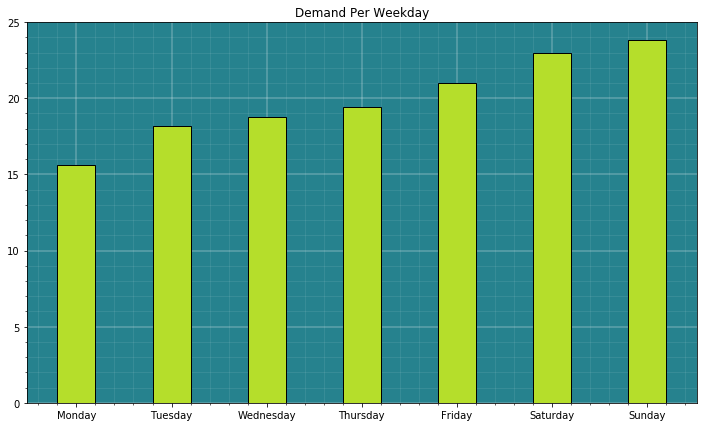

In [27]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(weekday_effect.index, weekday_effect['Mean'], color=viridis(8), width=.4,
      edgecolor='k', linewidth=1, alpha=1)
set_theme()
ax.set_axisbelow(True)
plt.title('Demand Per Weekday')
plt.show()

Let's make a boxplot, there is more information about the distribution of the values

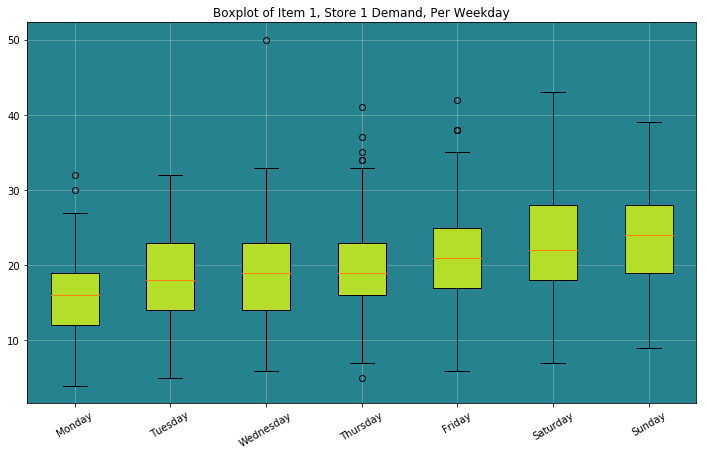

In [28]:
fig, ax = plt.subplots(figsize=(12, 7))
box = ax.boxplot(df_week_day.groupby('Weekday')['s1_i1'].apply(list), patch_artist=True)
ax.set_facecolor(viridis(4))
#ax.set_axisbelow(True)
color=viridis(8)
for patch in box['boxes']:
    patch.set_facecolor(color)
ax.grid(True, alpha=0.3, color='white')
locs, labels = plt.xticks([1, 2, 3, 4, 5, 6, 7], 
                          ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                           'Friday', 'Saturday', 'Sunday'], rotation=30)
plt.title('Boxplot of Item 1, Store 1 Demand, Per Weekday')
plt.show()

There is a seasonality (day of the week), so we will make 'shifted' data so values at time *t* are a function of time _t-h_, _h_ being the number of days prior. Let's give it two seasonality cycles, so 14 days. We will do that for the 10 items of store 1.

2.3.6 Effect of Month

In [29]:
day = pd.date_range('2013-01-01', '2017-12-31', freq='D').to_series()

In [30]:
month = pd.concat([df.iloc[:, 0], day.dt.month], axis=1, sort=False)

In [31]:
month.columns = ['Demand', 'Month'] 

In [32]:
month_effect = month.groupby('Month').mean()
month_effect.index = ['January', 'February', 'March', 'April', 
                    'May', 'June', 'July', 'August', 'September',
                    'October', 'November', 'December']
month_effect.columns = ['Mean']
month_effect

,Mean
January,13.709677
February,14.631206
March,17.600000
April,20.786667
May,22.245161
June,24.833333
July,25.967742
August,22.529032
September,21.386667
October,19.645161


We will visualize this relationship

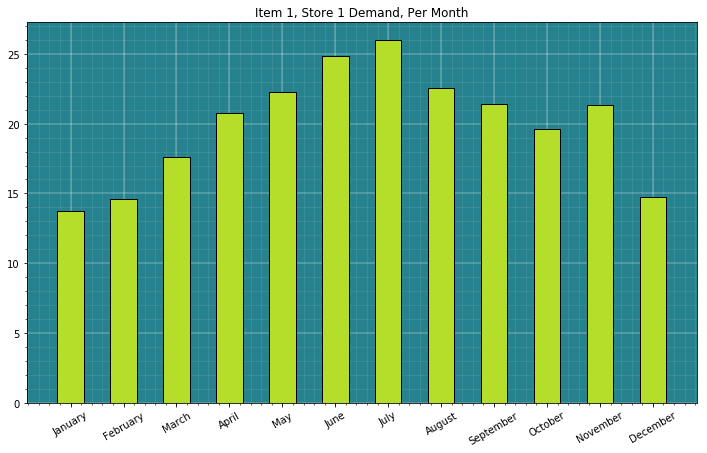

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(month_effect.index, month_effect['Mean'], color=viridis(8), width=.5, 
      edgecolor='k', linewidth=1)
set_theme()
ax.set_axisbelow(True)
plt.xticks(rotation=30)
plt.title('Item 1, Store 1 Demand, Per Month')
plt.show()

Let's make a boxplot, there is more information about the distribution of the values

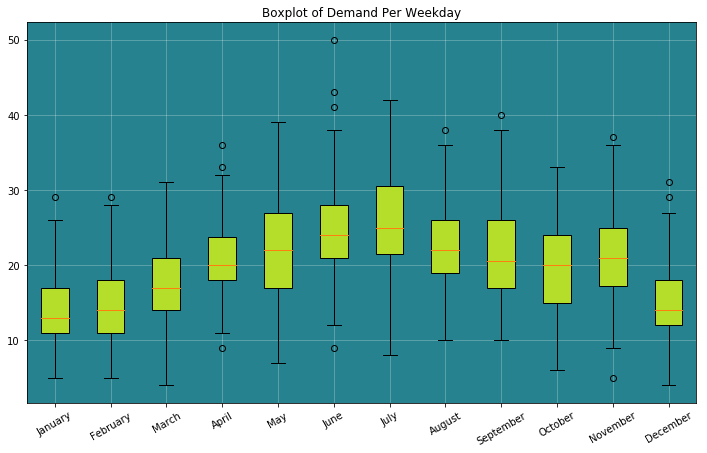

In [34]:
fig, ax = plt.subplots(figsize=(12, 7))
box = ax.boxplot(month.groupby('Month')['Demand'].apply(list), patch_artist=True)
ax.set_facecolor(viridis(4))
#ax.set_axisbelow(True)
color=viridis(8)
for patch in box['boxes']:
    patch.set_facecolor(color)
ax.grid(True, alpha=0.3, color='white')
locs, labels = plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                          ['January', 'February', 'March', 'April', 
                    'May', 'June', 'July', 'August', 'September',
                    'October', 'November', 'December'], rotation=30)
plt.title('Boxplot of Demand Per Weekday')
plt.show()

2.3.7 Time plot - Monthly

In [35]:
df1 = pd.DataFrame(timeseries, index=dates, columns=['Demand'])

In [36]:
date_frame = pd.DataFrame(df1.resample('M').sum(), index=df1.resample('M').sum().index)

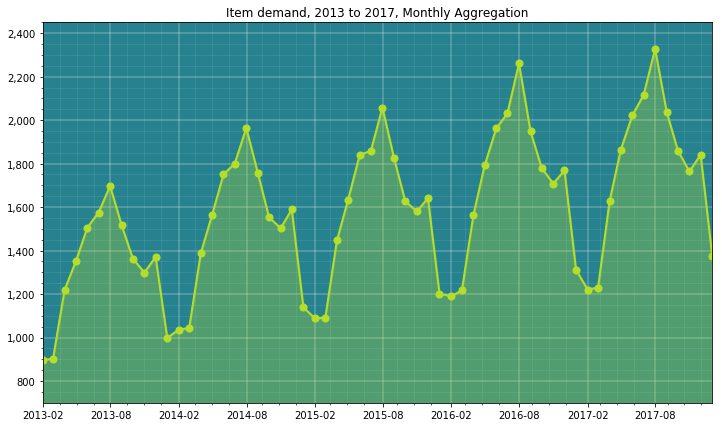

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(date_frame.index, date_frame['Demand'], 
        lw=2, color=viridis(8))
ax.fill_between(date_frame.index, 500, date_frame['Demand'], 
       lw=2, color=viridis(8), alpha=.3)
ax.scatter(date_frame.index, date_frame['Demand'], 
        marker='o', color=viridis(8), s=50)
ax.set_axisbelow(True)
plt.ylim(700, 2450)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim(date_frame.index[0], date_frame.index[-1])
set_theme()
plt.title('Item demand, 2013 to 2017, Monthly Aggregation')
plt.show()

### 3. Feature engineering

**3.1 Shifted values**

3.1.1 Making shifted values

In [38]:
ts = pd.DataFrame(timeseries, columns=['Demand'])

In [39]:
for i in range(1, 15):
    ts.loc[:, 'T–%s'%i] = ts.loc[:, 'Demand'].shift(i)

In [40]:
ts.head(10)

,Demand,T–1,T–2,T–3,T–4,T–5,T–6,T–7,T–8,T–9,T–10,T–11,T–12,T–13,T–14
0,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,34,32.0,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23,34.0,32.0,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27,23.0,34.0,32.0,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,27,27.0,23.0,34.0,32.0,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
9,29,27.0,27.0,23.0,34.0,32.0,31.0,28.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN


3.1.2 Dealing with NaN

In [41]:
ts = ts.fillna(method='ffill', axis=1)
ts.head()

,Demand,T–1,T–2,T–3,T–4,T–5,T–6,T–7,T–8,T–9,T–10,T–11,T–12,T–13,T–14
0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
1,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
2,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
3,31.0,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
4,32.0,31.0,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0


**3.2 Month effect**

In [42]:
ts.loc[:, 'Month'] = month.loc[:, 'Month'].values

In [43]:
ts.head()

,Demand,T–1,T–2,T–3,T–4,T–5,T–6,T–7,T–8,T–9,T–10,T–11,T–12,T–13,T–14,Month
0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1
1,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1
2,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1
3,31.0,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1
4,32.0,31.0,28.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1


**3.2 Weekday effect**

In [44]:
ts.loc[:, 'Weekday'] = day_of_week.dt.dayofweek.values

In [45]:
ts.head().iloc[:, 5:]

,T–5,T–6,T–7,T–8,T–9,T–10,T–11,T–12,T–13,T–14,Month,Weekday
0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1,1
1,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1,2
2,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1,3
3,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1,4
4,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,1,5


**3.4 Get dummies**

3.4.1 Month

In [46]:
month_dummies = pd.get_dummies(ts.loc[:, 'Month'], prefix_sep='_', prefix='Month')

In [47]:
ts = pd.concat([ts, month_dummies], axis=1, sort=False)

In [48]:
ts.head().iloc[:, 15:]

,Month,Weekday,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1,2,1,0,0,0,0,0,0,0,0,0,0,0
2,1,3,1,0,0,0,0,0,0,0,0,0,0,0
3,1,4,1,0,0,0,0,0,0,0,0,0,0,0
4,1,5,1,0,0,0,0,0,0,0,0,0,0,0


In [49]:
ts.drop('Month', axis=1, inplace=True)

3.4.2 Weekday

In [50]:
day_dummies = pd.get_dummies(ts.loc[:, 'Weekday'], prefix_sep='_', prefix='Day')

In [51]:
ts = pd.concat([ts, day_dummies], axis=1, sort=False)

In [52]:
ts.head().iloc[:, 20:]

,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**3.5 Changing data type**

In [53]:
df = ts.astype(np.float32)
ts = ts.values.astype(np.float32)

**3.6 Separating the `X` and `y`**

Train: 4 first years. Test: 1 last year.

In [54]:
X_train = df.iloc[:(365*4+1), 1:].values
X_test = df.iloc[(365*4+1):, 1:].values
y_train = df.iloc[:(365*4+1), 0].values
y_test = df.iloc[(365*4+1):, 0].values

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1461, 34), (365, 34), (1461,), (365,))

In [56]:
y_train

array([27., 27., 28., ..., 42., 44., 47.], dtype=float32)

### 4. Time series forecasting

**4.1 Linear Regression**

4.1.1 Instantiating the class

In [57]:
lm = LinearRegression()

4.1.2 Training the model

In [58]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

4.1.3 Making predictions

In [59]:
y_pred = lm.predict(X_test)

4.1.4 Evaluating predictions

In [60]:
mae_lin_reg = mean_absolute_error(y_test, y_pred)
mae_lin_reg

1.2970371

4.1.5 Plotting the predictions

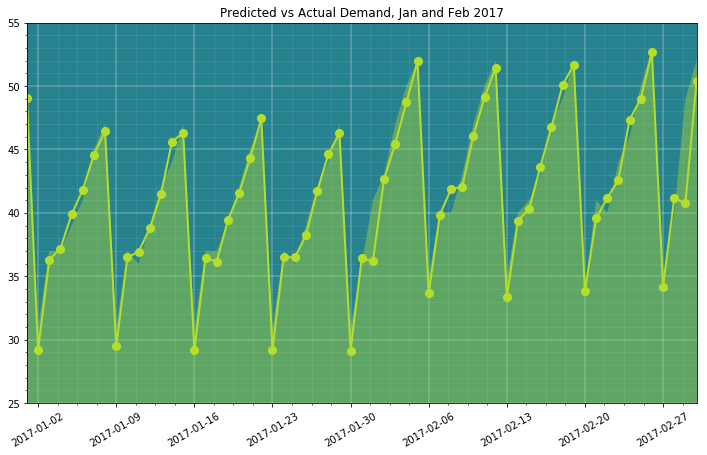

In [61]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.1.6 Metrics dataframe

In [62]:
metrics = pd.DataFrame(mae_lin_reg, 
                       columns=['Lin. Reg.'], 
                       index=['Mean Absolute Error']).T
metrics

,Mean Absolute Error
Lin. Reg.,1.297037


4.1.7 Plotting metrics

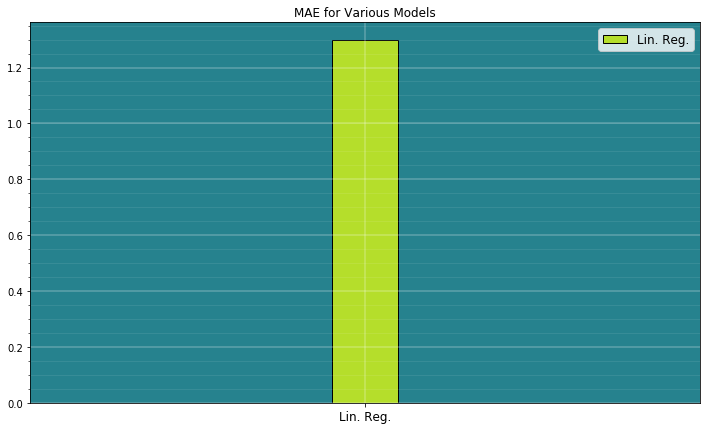

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=1, 
       alpha=1)

plt.xlim(-5, 5)
plt.legend(metrics.index, fontsize='large')
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.2 Decision Tree Regressor**

4.2.1 Instantiating the class

In [64]:
tree = DecisionTreeRegressor(min_samples_leaf=3, max_depth=7, min_samples_split=9)

In [65]:
tree.get_params().keys()

dict_keys(['criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

4.2.2 Training the model / grid search

In [66]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=9, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [67]:
# grid_params = {'max_depth':np.arange(5, 40),
#                'min_impurity_decrease':np.linspace(0, 1, 20),
#                'min_samples_split':np.arange(2, 20),
#                'min_impurity_split':mp.linspace(0.0001, 0.1, 20)
#                }

In [68]:
# grid_tree = GridSearchCV(estimator=tree, param_grid=grid_params, cv=3, n_jobs=-1, verbose=2)

In [69]:
# start = time()
# grid_tree.fit(X_train, y_train)
# stop = time()
# print(str(stop-start), 'seconds')
# Beep(1200, 500)

In [70]:
# grid_tree.best_params_

4.2.3 Making predictions

In [71]:
y_pred = tree.predict(X_test)

4.2.4 Evaluating predictions

In [72]:
mae_tree = mean_absolute_error(y_test, y_pred)
mae_tree

1.8110238784819532

4.2.5 Plotting the predictions

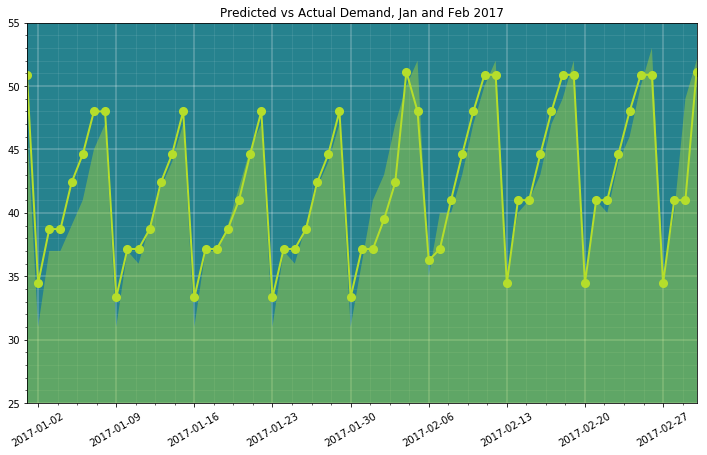

In [73]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.2.6 Metrics dataframe

In [74]:
metrics_tree = pd.DataFrame(mae_tree, 
                       columns=['Decision Tree'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_tree], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024


4.2.7 Plotting metrics

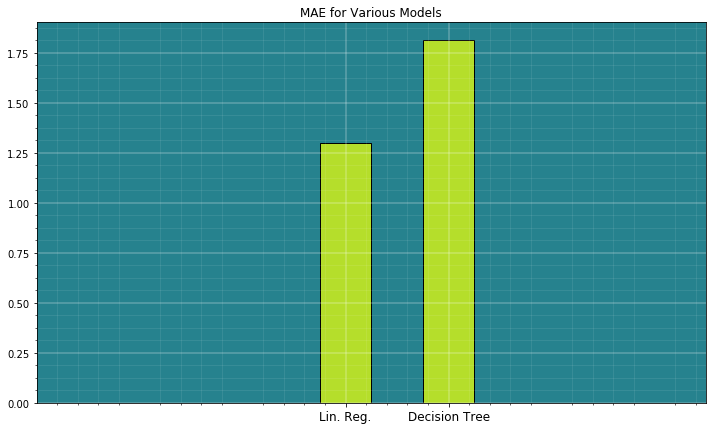

In [75]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-3., 3.5)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.3 Support Vector Machine Regressor**

4.3.1 Instantiating the class

In [76]:
svr = LinearSVR()

In [77]:
svr.get_params().keys()

dict_keys(['C', 'dual', 'epsilon', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'random_state', 'tol', 'verbose'])

4.3.2 Training the model / grid search

In [78]:
grid_params = {'C':np.linspace(.001, 8, 1_00)
               }

In [79]:
grid_svr = GridSearchCV(estimator=svr, param_grid=grid_params, cv=3, n_jobs=-1)

In [80]:
start = time()
grid_svr.fit(X_train, y_train)
stop = time()
print(str(int(stop-start)), 'seconds')
Beep(1_200, 5_00)

17 seconds


In [81]:
grid_svr.best_params_

{'C': 4.040898989898991}

4.3.3 Making predictions

In [82]:
y_pred = grid_svr.best_estimator_.predict(X_test)

4.3.4 Evaluating predictions

In [83]:
mae_svr = mean_absolute_error(y_test, y_pred)
mae_svr

1.2217709385071467

4.3.5 Plotting the predictions

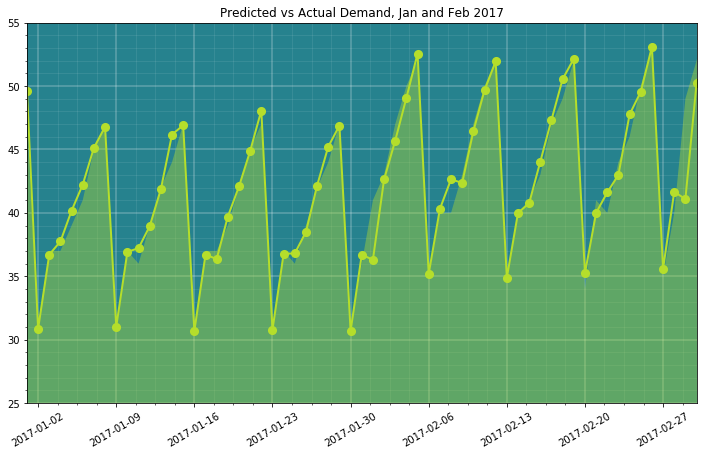

In [84]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.3.6 Metrics dataframe

In [85]:
metrics_svr = pd.DataFrame(mae_svr, 
                       columns=['Linear SVR'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_svr], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771


4.2.7 Plotting metrics

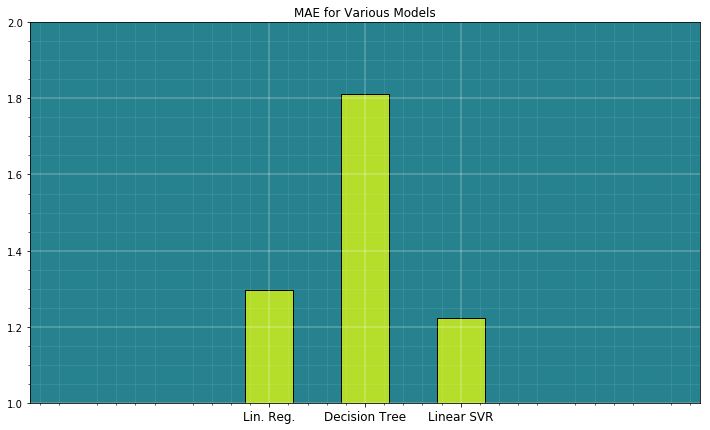

In [86]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-2.5, 4.5)
plt.ylim(1., 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.4 Dense Neural Network**

4.4.0 Re-scaling the data

In [87]:
# scaler = MinMaxScaler()

In [88]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

4.4.1 Building the neural network

In [90]:
model = Sequential([
    Dense(48, input_shape=(X_train.shape[1],)),
    Dense(96, activation='relu'),
    Dense(192, activation='elu'),
    Dense(1, activation='linear')
])

4.4.2 Compiling the model

In [91]:
model.compile(loss='mae', optimizer='adam')

4.4.3 Callbacks

In [92]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('dense_weights.h5', monitor='val_loss', save_best_only=True)
            ]

4.4.4 Training the model

In [95]:
start = time()
dense_history = model.fit(X_train, y_train,
                epochs=100,
                callbacks=callbacks,
                verbose=0,
                validation_data=[X_test, y_test])
Beep(1000, 500)
stopwatch()

0 seconds


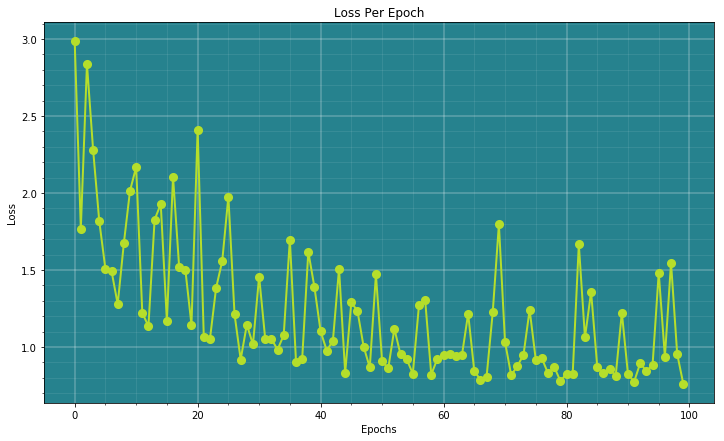

In [94]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(np.arange(len(dense_history.history['val_loss'])), dense_history.history['val_loss'], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(np.arange(len(dense_history.history['val_loss'])), dense_history.history['val_loss'], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
set_theme()
plt.title('Loss Per Epoch')
plt.show()

4.4.5 Making predictions

In [96]:
model = load_model('dense_weights.h5')

In [97]:
y_pred = model.predict(X_test)

4.4.6 Evaluating predictions

In [98]:
mae_dense = mean_absolute_error(y_test, y_pred)
mae_dense

0.7586645

4.4.7 Plotting the predictions

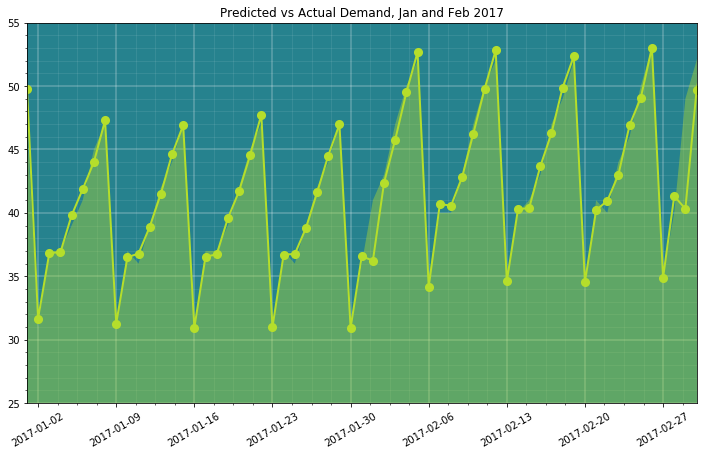

In [99]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.4.8 Metrics dataframe

In [100]:
#metrics.drop('Dense NN', axis=0, inplace=True)

In [101]:
metrics_dense = pd.DataFrame(mae_dense, 
                       columns=['Dense NN'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_dense], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771
Dense NN,0.758664


4.4.9 Plotting metrics

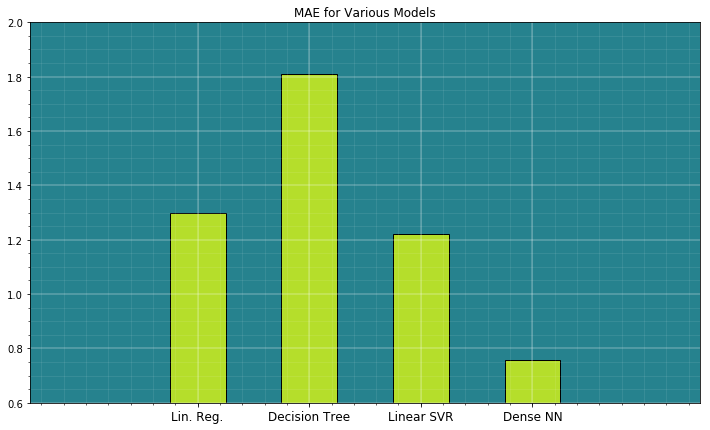

In [102]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-1.5, 4.5)
plt.ylim(.6, 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.5 LSTM Neural Network**

In [103]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [104]:
scaler = MinMaxScaler()

In [105]:
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [106]:
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], 1, X_test.shape[1])

4.5.1 Building the neural network

In [107]:
# model = Sequential([
#     LSTM(64, input_shape=(X_test_scaled.shape[1:])),
#     Dense(1, activation='linear')
#     ])

4.5.2 Compiling the model

In [108]:
# model.compile(loss='mae', optimizer='adam')

4.5.3 Callbacks

In [109]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=1_00, restore_best_weights=True),
#     ModelCheckpoint('lstm_weights.h5', monitor='val_loss', save_best_only=True)
#             ]

4.5.4 Training the model

In [110]:
# lstm_history = model.fit(X_train_scaled, y_train,
#                 epochs=2_000,
#                 callbacks=callbacks,
#                 verbose=0,
#                 validation_data=[X_test_scaled, y_test])
# Beep(1000, 500)

In [111]:
# fig, ax = plt.subplots(figsize=(12, 7))
# ax.scatter(np.arange(len(lstm_history.history['val_loss']))[::5], lstm_history.history['val_loss'][::5], 
#         lw=2, color=viridis(8), alpha=1, s=50)
# ax.plot(np.arange(len(lstm_history.history['val_loss']))[::5], lstm_history.history['val_loss'][::5], 
#         lw=2, color=viridis(8), alpha=1)
# ax.set_axisbelow(True)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# set_theme()
# plt.yscale('log')
# plt.title('Loss Per Epoch')
# plt.show()

4.5.5 Making predictions

In [112]:
model = load_model('lstm_weights.h5')

In [113]:
y_pred = model.predict(X_test_scaled)

4.5.6 Evaluating predictions

In [114]:
mae_lstm = mean_absolute_error(y_test, y_pred)
mae_lstm

0.7804736

4.5.7 Plotting the predictions

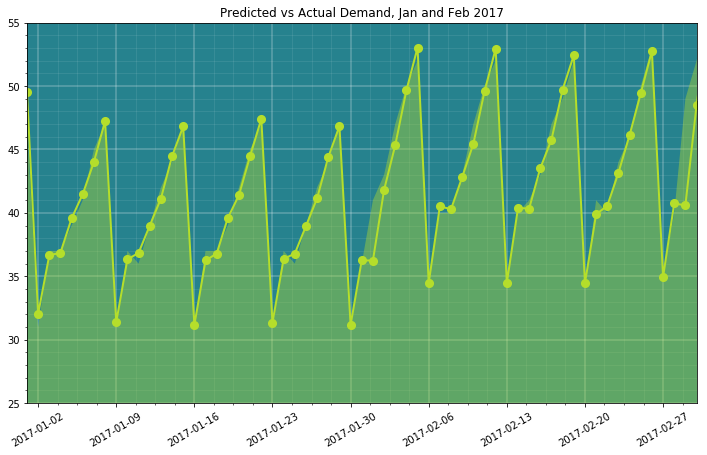

In [115]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.5.8 Metrics dataframe

In [116]:
# metrics.drop('LSTM', axis=0, inplace=True)

In [117]:
metrics_lstm = pd.DataFrame(mae_lstm, 
                       columns=['LSTM'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_lstm], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771
Dense NN,0.758664
LSTM,0.780474


4.5.9 Plotting metrics

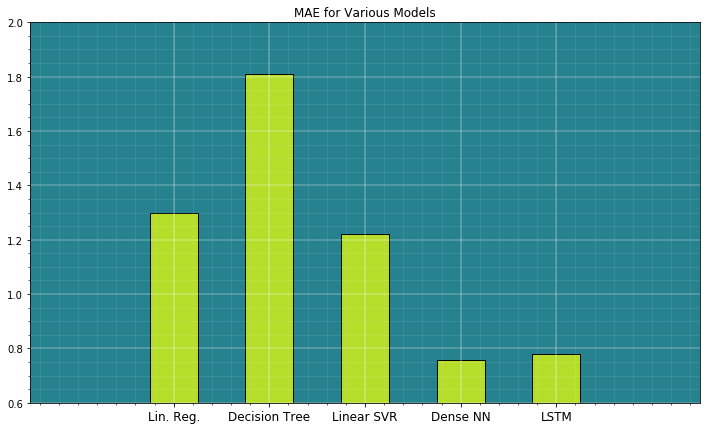

In [118]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-1.5, 5.5)
plt.ylim(.6, 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.6 Simple RNN**

In [119]:
step = 14

In [120]:
test = np.append(ts[1461:, 0],np.repeat(ts[1461:, 0],step))
train = np.append(ts[:1461, 0],np.repeat(ts[:1461, 0],step))

In [121]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [122]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [123]:
trainX.shape

(21901, 14)

In [124]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [125]:
trainX.shape, testX.shape

((21901, 1, 14), (5461, 1, 14))

4.5.1 Building the neural network

In [134]:
model = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(1, 14), activation='relu'),
    SimpleRNN(64, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
    ])

4.5.2 Compiling the model

In [135]:
model.compile(loss='mae', optimizer='adam')

4.5.3 Callbacks

In [136]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('simple_rnn_weights.h5', monitor='val_loss', save_best_only=True)
            ]

4.5.4 Training the model

In [137]:
start = time()
lstm_history = model.fit(trainX, trainY,
                epochs=2_000,
                callbacks=callbacks,
                verbose=0,
                validation_data=[testX, testY])
stopwatch()

15 minutes


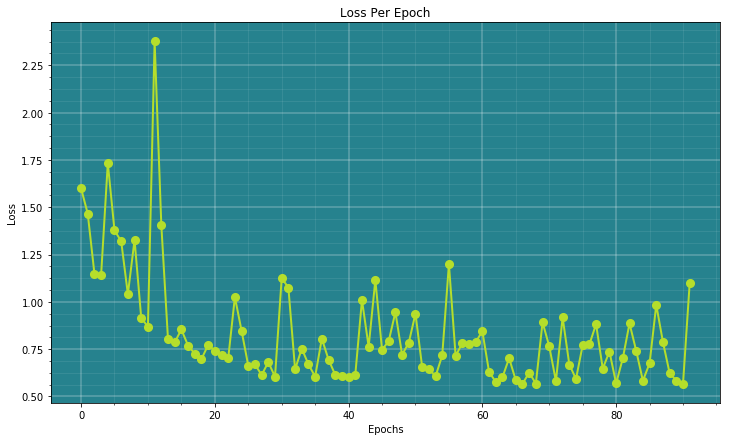

In [138]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(np.arange(len(lstm_history.history['val_loss'])), lstm_history.history['val_loss'], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(np.arange(len(lstm_history.history['val_loss'])), lstm_history.history['val_loss'], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
set_theme()
plt.title('Loss Per Epoch')
plt.show()

4.5.5 Making predictions

In [139]:
model = load_model('simple_rnn_weights.h5')

In [140]:
y_pred = model.predict(testX)

4.5.6 Evaluating predictions

In [141]:
mae_rnn = mean_absolute_error(testY, y_pred)
mae_rnn 

0.56734276

4.5.7 Plotting the predictions

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 32)             1504      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 8,373
Trainable params: 8,373
Non-trainable params: 0
_________________________________________________________________


4.5.8 Metrics dataframe

In [144]:
metrics_rnn = pd.DataFrame(mae_rnn, 
                       columns=['Simple RNN'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_rnn], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771
Dense NN,0.758664
LSTM,0.780474
Simple RNN,0.567343


4.5.9 Plotting metrics

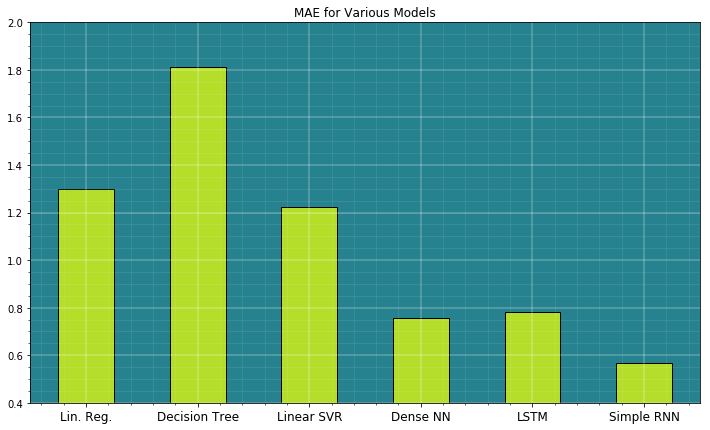

In [147]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-.5, 5.5)
plt.ylim(.4, 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

**4.7 PyTorch**

Is the GPU available?

In [148]:
torch.cuda.is_available()

True

In [149]:
device = torch.device('cuda')

In [150]:
N = 8

Sending the tensors to the GPU

In [151]:
x = torch.tensor(X_train).to(device)
y = torch.tensor(y_train).view(y_train.shape[0], 1).to(device)

Building the model

In [152]:
model = torch.nn.Sequential(
          torch.nn.Linear(X_train.shape[1], 32),
          torch.nn.ReLU(),
          torch.nn.Linear(32, 64),
          torch.nn.ReLU(),
          torch.nn.Linear(64, 1),
        ).to(device)

Selecting a loss function

In [154]:
loss_fn = torch.nn.L1Loss()

Running the neural sub net

In [155]:
start = time()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(1, 50_000+1):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if t % 10_000 == 0 and t > 0:
        print(f'Epoch: {t:,} — Loss: {loss.item()}')
    model.zero_grad()
    loss.backward()
    optimizer.step()
print('Done.')
print(); stopwatch()

Epoch: 10,000 — Loss: 0.5880120396614075
Epoch: 20,000 — Loss: 0.5510008931159973
Epoch: 30,000 — Loss: 0.5533043146133423
Epoch: 40,000 — Loss: 0.5398314595222473
Epoch: 50,000 — Loss: 0.5169631242752075
Done.

5 minutes


4.5.5 Making predictions

In [156]:
y_pred = model(torch.from_numpy(X_test).to(device))

4.5.6 Evaluating predictions

In [157]:
mae_torch = mean_absolute_error(y_test, y_pred.cpu().detach().numpy())
mae_torch 

0.77277946

4.5.8 Metrics dataframe

In [158]:
metrics_torch = pd.DataFrame(mae_torch, 
                       columns=['PyTorch'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_torch], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771
Dense NN,0.758664
LSTM,0.780474
Simple RNN,0.567343
PyTorch,0.772779


4.5.9 Plotting metrics

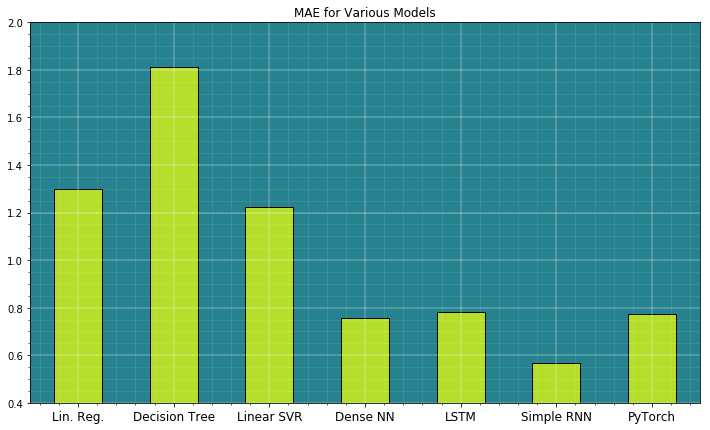

In [159]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-.5, 6.5)
plt.ylim(.4, 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

#### **ConvNet**

4.4.0 Making sequences

In [160]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
        
		end_ix = i + n_steps
        
		if end_ix > len(sequence)-1:
			break
            
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [161]:
n_steps = 14

In [162]:
# X_train = df.iloc[:(365*4+1), 1:].values
# X_test = df.iloc[(365*4+1):, 1:].values
# y_train = df.iloc[:(365*4+1), 0].values
# y_test = df.iloc[(365*4+1):, 0].values

In [163]:
X, y = split_sequence(df.values[:1461, 0], n_steps)

In [185]:
X_tst, y_tst = split_sequence(df.values[1461:, 0], n_steps)

In [164]:
n_features = 1

In [187]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_tst = X_tst.reshape((X_tst.shape[0], X_tst.shape[1], n_features))

In [166]:
X.shape

(1447, 14, 1)

4.1.1 Building the classifier

In [188]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

4.4.2 Compiling the model

In [189]:
model.compile(optimizer='adam', loss='mae')

4.4.3 Callbacks

In [190]:
callbacks = [
    ModelCheckpoint('cnn_weights.h5'),
    EarlyStopping(monitor='val_loss', patience=50)
            ]

4.4.4 Training the model

In [192]:
start = time()
cnn_history = model.fit(X, y,
                epochs=2000,
                callbacks=callbacks,
                verbose=0,
                validation_data=[X_tst, y_tst])
Beep(1000, 500)
stopwatch()

7 minutes


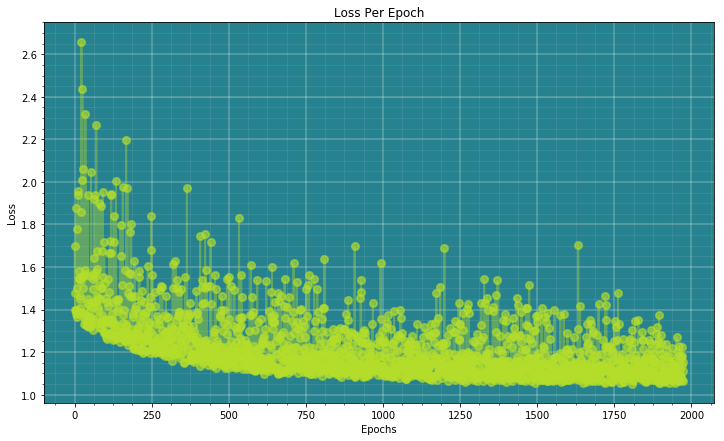

In [205]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(np.arange(len(cnn_history.history['val_loss'][25:])), cnn_history.history['val_loss'][25:], 
        lw=2, color=viridis(8), alpha=.6, s=50)
ax.plot(np.arange(len(cnn_history.history['val_loss'][25:])), cnn_history.history['val_loss'][25:], 
        lw=2, color=viridis(8), alpha=.4)
ax.set_axisbelow(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
set_theme()
plt.title('Loss Per Epoch')
plt.show()

4.4.5 Making predictions

In [206]:
model = load_model('cnn_weights.h5')

In [207]:
y_pred = model.predict(X_tst)

4.4.6 Evaluating predictions

In [208]:
mae_cnn = mean_absolute_error(y_tst, y_pred)
mae_cnn

1.0618275

4.4.7 Plotting the predictions

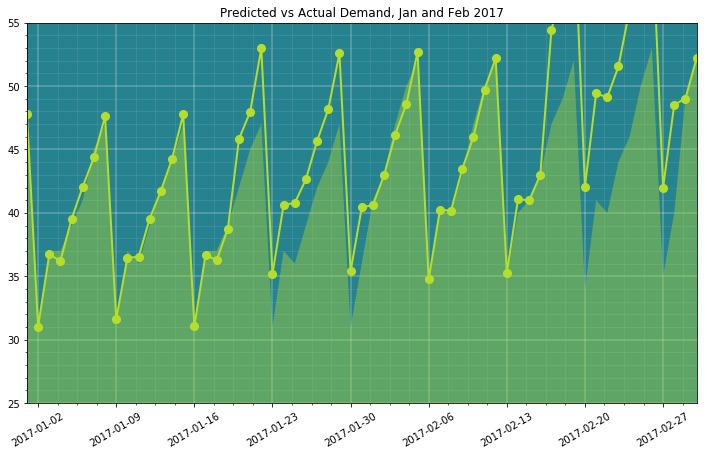

In [209]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[365*4+1:365*4+63+1], 0, y_test[:62+1], 
        lw=0, color=viridis(8), alpha=.4)
ax.scatter(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1, s=50)
ax.plot(dates[365*4+1:365*4+63+1], y_pred[:62+1], 
        lw=2, color=viridis(8), alpha=1)
ax.set_axisbelow(True)
plt.ylim(25, 55)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim('2017-01-01', '2017-03-02')
plt.xticks(rotation=30)
set_theme()
plt.title('Predicted vs Actual Demand, Jan and Feb 2017')
plt.show()

4.4.8 Metrics dataframe

In [210]:
metrics_cnn = pd.DataFrame(mae_cnn, 
                       columns=['ConvNet'], 
                       index=['Mean Absolute Error']).T
metrics = pd.concat([metrics, metrics_cnn], axis=0, sort=True)
metrics

,Mean Absolute Error
Lin. Reg.,1.297037
Decision Tree,1.811024
Linear SVR,1.221771
Dense NN,0.758664
LSTM,0.780474
Simple RNN,0.567343
PyTorch,0.772779
ConvNet,1.061828


4.4.9 Plotting metrics

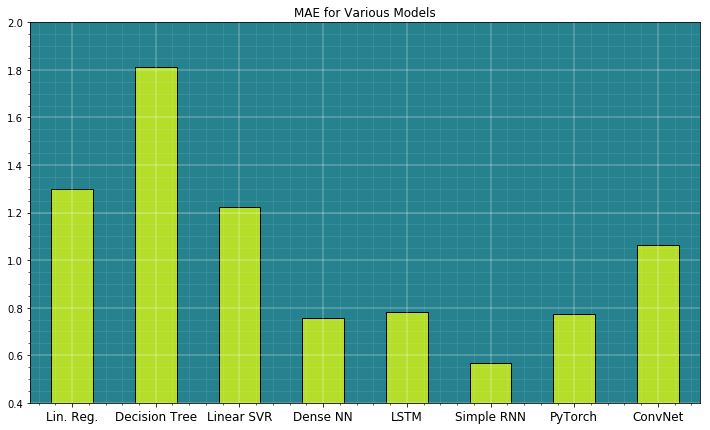

In [214]:
fig, ax = plt.subplots(figsize=(12, 7))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 0].values, color=viridis(8), 
       edgecolor='k', linewidth=1, width=.5, 
       alpha=1)

plt.xlim(-.5, 7.5)
plt.ylim(.4, 2.)
plt.title('MAE for Various Models', fontsize=12)
plt.xticks(fontsize=12)
plt.show()